In [79]:
import pyaudio
import numpy as np
import scipy.stats as sts
import scipy.signal as sgl
import matplotlib.pyplot as plt

### Aufgabe 1

##### a)
Schreiben Sie ein Python-Programm zur Aufnahme kurzer akustischer Signale über die Soundkarte mithilfe des Objektes audiorecorder. Orientieren Sie sich dabei an dem in Moodle zur Verfügung gestellten Codebeispiel (J.Keppler). Speichern Sie das Signal mit einem automatisch generierten eindeutigen Namen mithilfe des Befehls numpy.save(). Nehmen Sie als Beispiel eine beliebige Spracheingabe auf und stellen Sie diese mit korrekter Achsenbeschriftung als Diagramm dar.

##### b)
 Ergänzen Sie Ihr Aufnahmeprogramm um eine Triggerfunktion, die alle Samples nahe an 0 abschneidet, die vor dem eigentlichen Beginn des Signals aufgenommen wurden (s. Codebeispiel). Auf diese Weise stellen Sie sicher, dass alle Signale bei den späteren Vergleichsoperation zum gleichen Zeitpunkt beginnen. Schneiden Sie Ihr Signal ab dem Triggerzeitpunkt so aus, dass das ausgeschnittene Signal genau 1 s lang ist und füllen im Programm die möglicherweise fehlenden Samples mit Nullen auf. Überprüfen Sie die Korrektheit Ihrer Triggerfunktion durch erneute Darstellung des Signals als Diagramm

done

Start: 34557


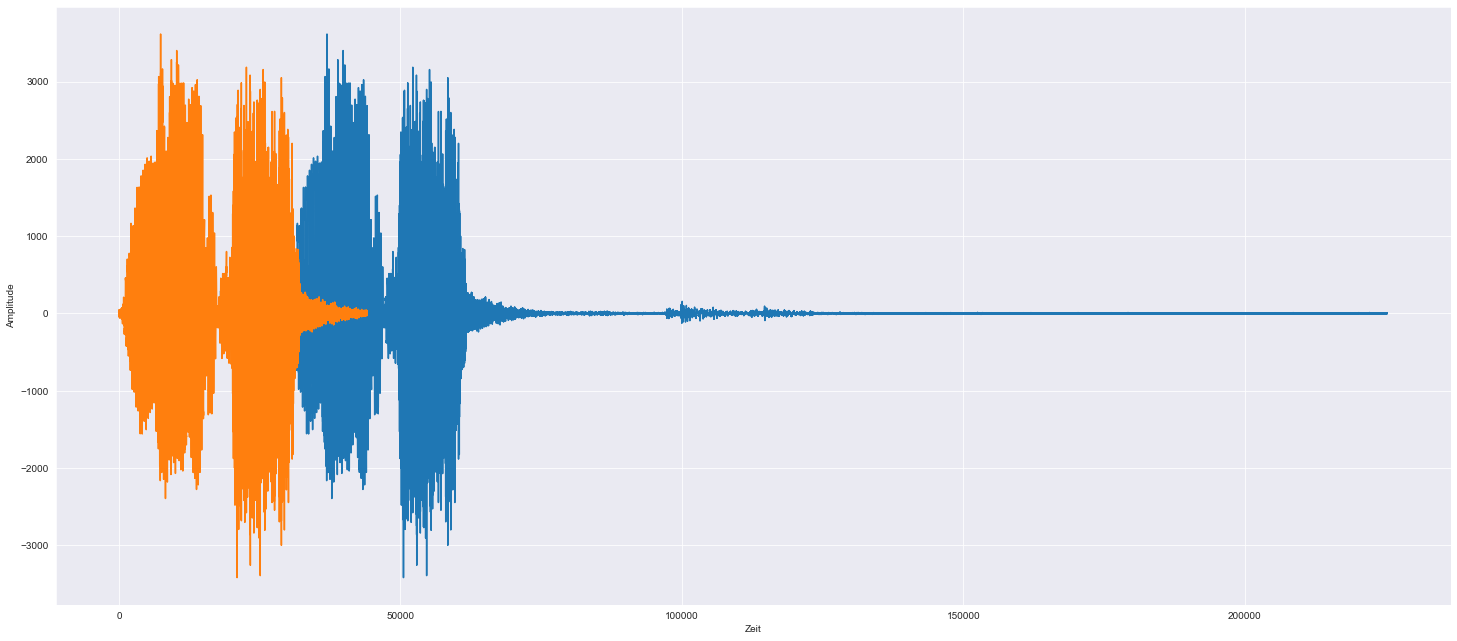

In [374]:
#Aufnahme

# a) + b)

FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220


p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=1,
                rate=SAMPLEFREQ,
                input=True,
                frames_per_buffer=FRAMESIZE)

data = stream.read(NOFFRAMES * FRAMESIZE)
decd = np.frombuffer(data, np.int16)
#Zur Info: frombuffer da fromstring nicht mehr funktioniert


stream.stop_stream()
stream.close()

p.terminate()

print('done')



count = 0
start = 0
TOLERANZBEREICH = 5000

print()


for i in decd:
    if i > 2000:
        start = count
        print("Start: " + str(start))
        break
    count += 1

trigger = decd[(start - TOLERANZBEREICH):(start + SAMPLEFREQ - TOLERANZBEREICH)]
#Samplefreq ist genau die Zahl der Abtastungen in einer Sekunde


np.save('test', trigger)

plt.figure(figsize=(25, 11))

plt.plot(decd)
plt.plot(trigger)

plt.xlabel("Zeit")
plt.ylabel("Amplitude")

plt.show()


##### c)
Bestimmen Sie mithilfe Ihres Codes aus Versuch 3 das Amplitudenspektrum des ausgeschnittenen Signals und stellen Sie dieses graphisch dar.

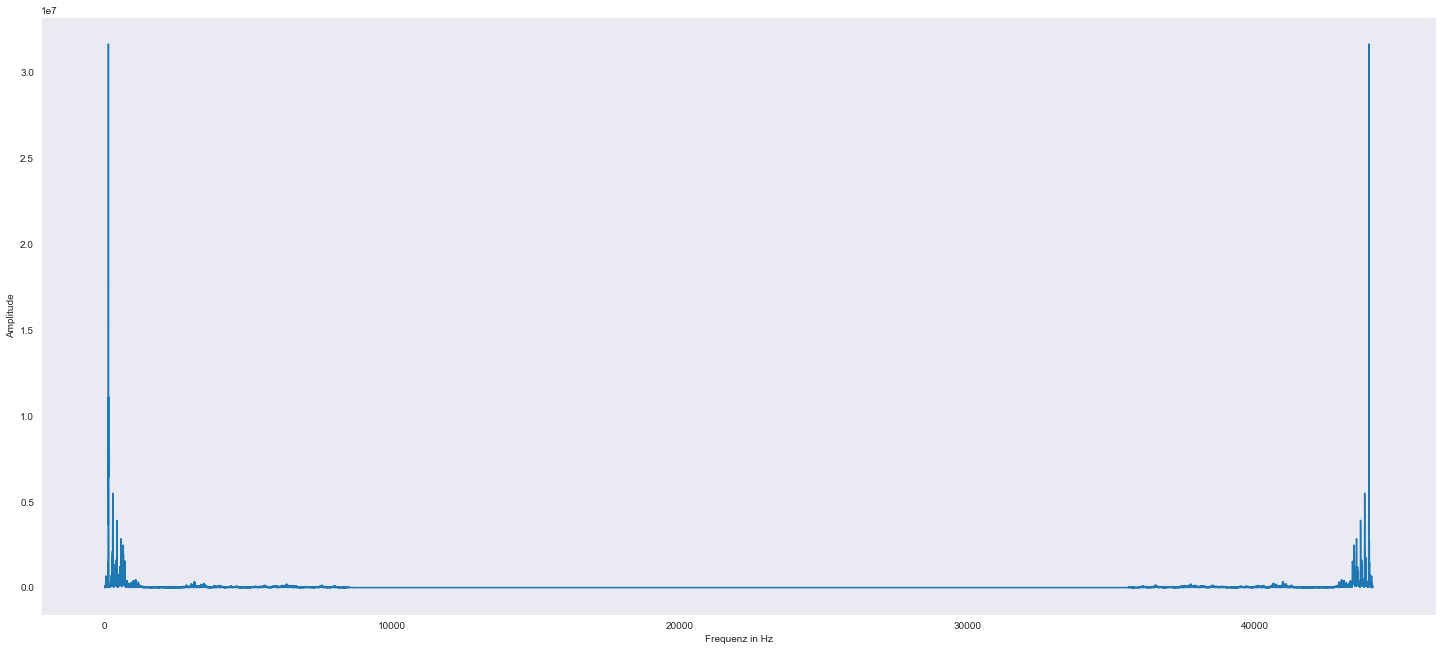

In [221]:
#Amplitudenspektrum

#c)

data = np.load("testHoch.npy")

ft = np.fft.fft(data)
t = 1

fq = []
for i in range(len(ft)):
    fq.append(i / t)


fig, ax = plt.subplots(figsize=(25, 11))
ax.grid()

ax.plot(fq, np.abs(ft))

ax.set_xlabel('Frequenz in Hz')
ax.set_ylabel('Amplitude')

plt.show()

##### d)
Implementieren Sie die in der Vorlesung gezeigte Methode des Windowing. Zerlegen Sie dazu das Signal in Abschnitte mit einer Länge von 512 Samples, die sich jeweils zur Hälfte überlappen. Gewichten Sie die Samples in jedem Fenster mit einer Gaußschen Fensterfunktion, die so gewählt wird, dass die Fensterbreite 4 Standardabweichungen entspricht. Führen Sie in jedem Fenster eine lokale Fouriertransformation durch und mitteln Sie dann die Fouriertransformierte über alle Fenster. Berechnen Sie daraus wieder das Amplitudenspektrum und überprüfen Sie die Korrektheit durch Vergleich der graphischen Darstellung mit dem Spektrum aus der vorigen Teilaufgabe

[[6.28974659e-15 6.28974659e-15 6.28974659e-15 ... 6.28974659e-15
  6.28974659e-15 6.28974659e-15]
 [2.45155219e-15 2.45155219e-15 2.45155219e-15 ... 2.45155219e-15
  2.45155219e-15 2.45155219e-15]
 [1.64474109e-15 1.64474109e-15 1.64474109e-15 ... 1.64474109e-15
  1.64474109e-15 1.64474109e-15]
 ...
 [1.29712781e-15 1.29712781e-15 1.29712781e-15 ... 1.29712781e-15
  1.29712781e-15 1.29712781e-15]
 [1.12138971e-15 1.12138971e-15 1.12138971e-15 ... 1.12138971e-15
  1.12138971e-15 1.12138971e-15]
 [9.37999103e-15 9.37999103e-15 9.37999103e-15 ... 9.37999103e-15
  9.37999103e-15 9.37999103e-15]]
[[2.44249065e-15 2.44249065e-15 2.44249065e-15 ... 2.44249065e-15
  2.44249065e-15 2.44249065e-15]
 [3.82525211e-16 3.82525211e-16 3.82525211e-16 ... 3.82525211e-16
  3.82525211e-16 3.82525211e-16]
 [1.71653934e-15 1.71653934e-15 1.71653934e-15 ... 1.71653934e-15
  1.71653934e-15 1.71653934e-15]
 ...
 [5.62887864e-17 5.62887864e-17 5.62887864e-17 ... 5.62887864e-17
  5.62887864e-17 5.62887864e-17]

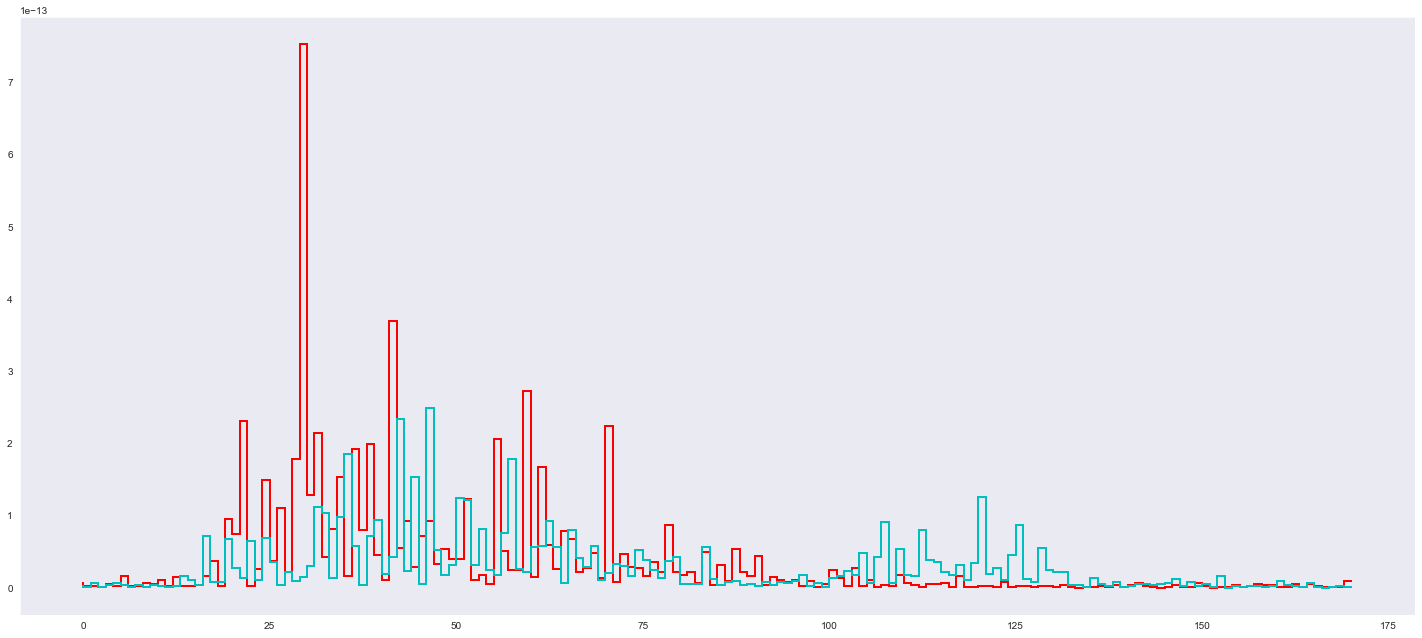

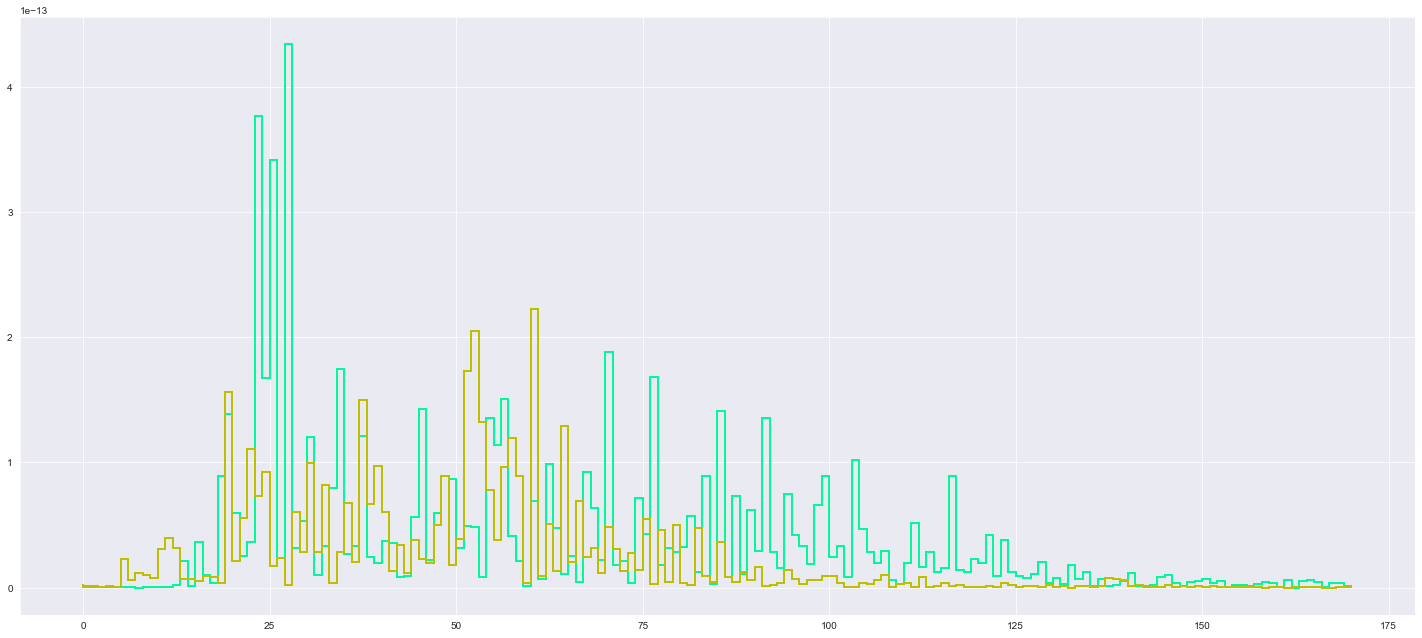

links-rechts:  0.08395383732919501
links-tief:  0.2547056647369077
links-hoch:  0.16763644636928776


In [352]:
# Windowing
#
# d)

T = 44100
FENSTER = 512
FENSTERSCHRITT = int(FENSTER / 2)
FENSTERZAHL = int((T / FENSTERSCHRITT) - 1)
GAUSSGLOCKE = sgl.gaussian(FENSTER, std=4)


a = np.load("testHoch.npy")
a2 = np.load("testTief.npy")
a3 = np.load("testRechts.npy")
a4 = np.load("testLinks.npy")

def windowing(data):

    pos = 0
    freq = np.zeros((FENSTERZAHL, FENSTER))

    for e in range(FENSTERZAHL):
        for f in range(FENSTER):
            freq[e, f] = np.mean(
                            np.abs(
                                np.fft.fft(
                                    data[pos] * GAUSSGLOCKE)))
            pos = pos + 1
        pos = pos - FENSTERSCHRITT

    for g in range(FENSTERZAHL):
        for h in range(FENSTER):
            freq[g, h] = freq[g, h] * GAUSSGLOCKE[h]

        freq[g] = np.abs(
                    np.mean(
                        np.fft.fft(
                            freq[g])))
    print(freq)
    return freq

b = windowing(a)
b2 = windowing(a2)
b3 = windowing(a3)
b4 = windowing(a4)
plt.figure(figsize=(25, 11))
plt.grid()
plt.plot(b, 'r', drawstyle='steps', label='Test-Hoch')
plt.plot(b3, 'c', drawstyle='steps', label='Test-Rechts')
plt.show()

plt.figure(figsize=(25, 11))
plt.plot(b4, color='mediumspringgreen', drawstyle='steps', label='Test-Links')
plt.plot(b2, 'y', drawstyle='steps', label='Test-Tief')
plt.show()

print("links-rechts: ", sts.pearsonr(b4.ravel(), b3.ravel())[0])
print("links-tief: ", sts.pearsonr(b4.ravel(), b2.ravel())[0])
print("links-hoch: ", sts.pearsonr(b4.ravel(), b.ravel())[0])

### Aufgabe 2

##### a)
Für den Spracherkenner brauchen wir zunächst die Referenzspektren für die vier Befehle ”Hoch”, ”Tief”, ”Links” und ”Rechts”. Nehmen Sie dazu jeweils 5 Beispiele pro Befehl auf und berechnen Sie deren Spektren mit der Windowing-Methode aus Aufgabe 1. Achten Sie darauf, das die 5 Beispiele vom selben Sprecher stammen. Das Referenzspektrum erhalten Sie durch Mittelung über die 5 Spektren. Stellen Sie Ihre 4 Referenzspektren im Protokoll graphisch dar.

In [351]:
# Referenzspektren
# a)

def spektrum(name):
    spektren = []
    for i in range(1,6):
        d = np.load(f'{name}{i}.npy') #Manuell überschreiben für hoch usw.
        spektren.append(windowing(d))

    return np.mean(spektren, 0)

meanhoch = spektrum("leHoch")
meantief = spektrum("leTief")
meanrechts = spektrum("leRechts")
meanlinks = spektrum("leLinks")
lmeanhoch = spektrum("lfhoch")

print(meanhoch)
print(meantief)

[[2.79715756e-17 2.79715756e-17 2.79715756e-17 ... 2.79715756e-17
  2.79715756e-17 2.79715756e-17]
 [6.50069106e-16 6.50069106e-16 6.50069106e-16 ... 6.50069106e-16
  6.50069106e-16 6.50069106e-16]
 [1.17961196e-16 1.17961196e-16 1.17961196e-16 ... 1.17961196e-16
  1.17961196e-16 1.17961196e-16]
 ...
 [1.77079923e-16 1.77079923e-16 1.77079923e-16 ... 1.77079923e-16
  1.77079923e-16 1.77079923e-16]
 [3.81828360e-16 3.81828360e-16 3.81828360e-16 ... 3.81828360e-16
  3.81828360e-16 3.81828360e-16]
 [1.24912136e-16 1.24912136e-16 1.24912136e-16 ... 1.24912136e-16
  1.24912136e-16 1.24912136e-16]]
[[2.25166840e-16 2.25166840e-16 2.25166840e-16 ... 2.25166840e-16
  2.25166840e-16 2.25166840e-16]
 [1.24806693e-16 1.24806693e-16 1.24806693e-16 ... 1.24806693e-16
  1.24806693e-16 1.24806693e-16]
 [4.09527028e-16 4.09527028e-16 4.09527028e-16 ... 4.09527028e-16
  4.09527028e-16 4.09527028e-16]
 ...
 [1.95401026e-16 1.95401026e-16 1.95401026e-16 ... 1.95401026e-16
  1.95401026e-16 1.95401026e-16]

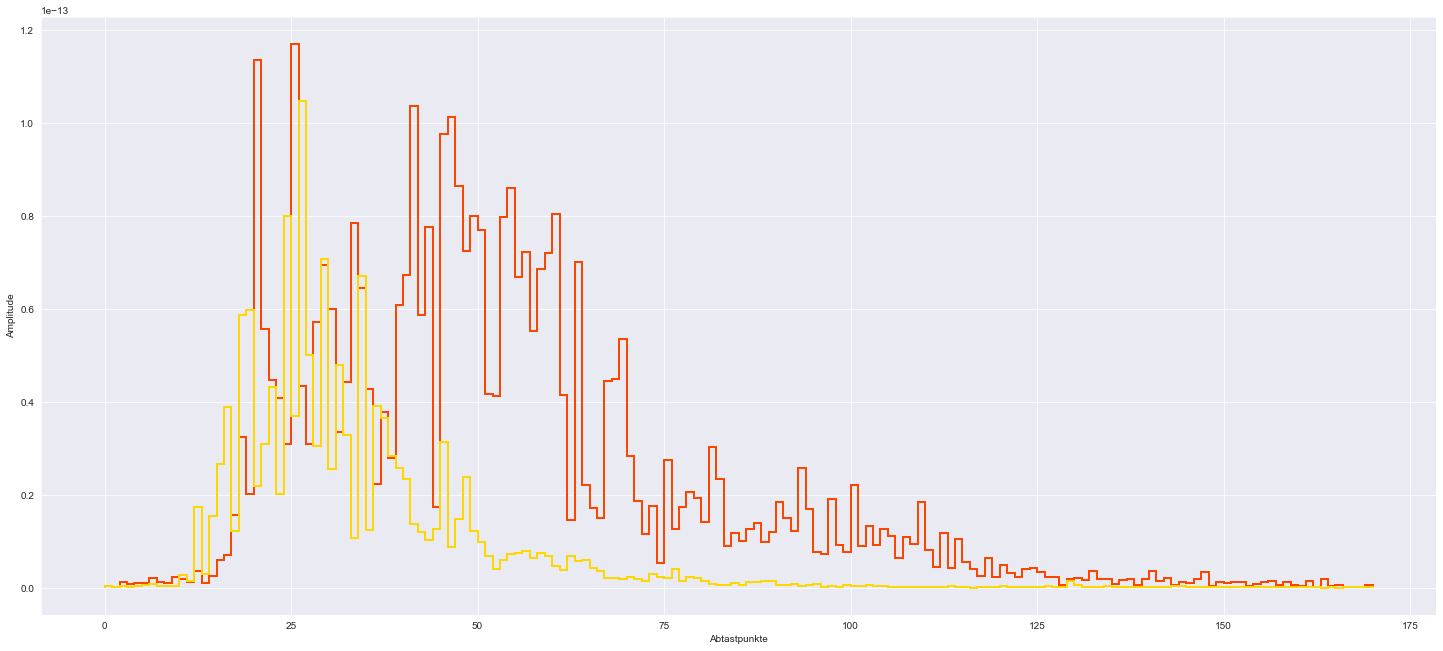

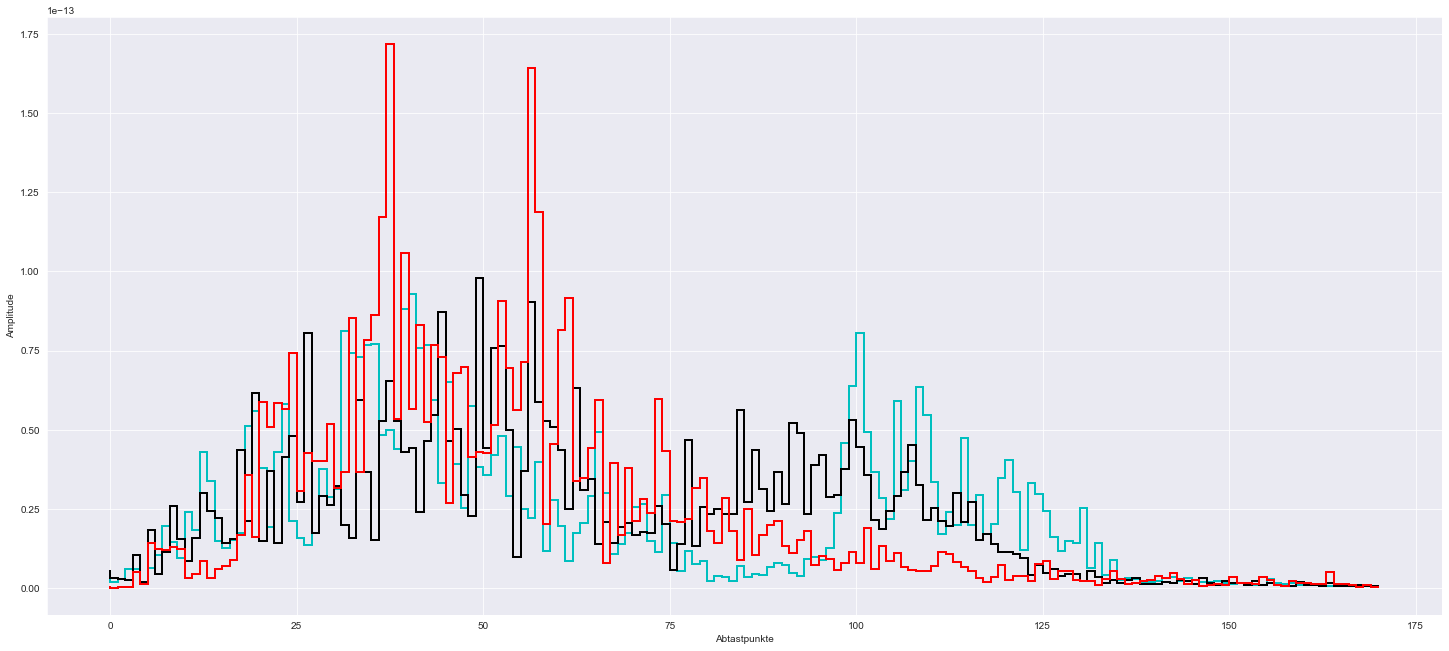

In [353]:

fig3, ax3 = plt.subplots(figsize=(25, 11))
ax3.plot(meanhoch, color='orangered', drawstyle='steps', label='hoch Lewin')
ax3.plot(lmeanhoch, color='gold', drawstyle='steps', label='hoch Leonie')
#ax3.plot(meantief.ravel(), color='deeppink', drawstyle='steps', label='tief Lewin')
ax3.set_xlabel('Abtastpunkte')
ax3.set_ylabel('Amplitude')


plt.show()

fig4, ax4 = plt.subplots(figsize=(25, 11))
ax4.plot(meanrechts, 'c', drawstyle='steps', label='rechts Lewin')
ax4.plot(meanlinks, 'k', drawstyle='steps', label='links Lewin')
ax4.plot(meantief, 'r', drawstyle='steps', label='tief Lewin')
ax4.set_xlabel('Abtastpunkte')
ax4.set_ylabel('Amplitude')


plt.show()

##### b)
Nehmen Sie einen Testdatensatz mit jeweils 5 Beispielen für jeden Befehl vom selben Sprecher wie im Trainingsdatensatz auf. Achtung: hier dürfen Sie nicht dieselben Beispiele wie im Training verwenden, ansonsten überschätzen Sie im Test die Leistungsfähigkeit Ihres Spracherkenners. Nehmen Sie zum Vergleich einen weiteren Testdatensatz gleicher Größe auf, der aber von einem anderen Sprecher stammt.

##### c)

Schreiben Sie eine Python-Routine zur Berechnung des Korrelationskoeffizienten nach Bravais-Pearson zum Vergleich zweier Eingabespektren. Testen Sie die Routine an ihren Referenzspektren: beim Vergleich identischer Spektren sollte die Korrelation 1 sein, bei verschiedenen Spektren nahe an 0.

In [354]:
#b)
lfmeanhoch = spektrum("lfhoch")
lfmeantief = spektrum("lftief")
lfmeanrechts = spektrum("lfrechts")
lfmeanlinks = spektrum("lflinks")

[[4.84730289e-16 4.84730289e-16 4.84730289e-16 ... 4.84730289e-16
  4.84730289e-16 4.84730289e-16]
 [1.00151787e-15 1.00151787e-15 1.00151787e-15 ... 1.00151787e-15
  1.00151787e-15 1.00151787e-15]
 [9.99682474e-16 9.99682474e-16 9.99682474e-16 ... 9.99682474e-16
  9.99682474e-16 9.99682474e-16]
 ...
 [2.90307153e-17 2.90307153e-17 2.90307153e-17 ... 2.90307153e-17
  2.90307153e-17 2.90307153e-17]
 [5.28450416e-17 5.28450416e-17 5.28450416e-17 ... 5.28450416e-17
  5.28450416e-17 5.28450416e-17]
 [3.89568068e-16 3.89568068e-16 3.89568068e-16 ... 3.89568068e-16
  3.89568068e-16 3.89568068e-16]]
[[1.67829453e-16 1.67829453e-16 1.67829453e-16 ... 1.67829453e-16
  1.67829453e-16 1.67829453e-16]
 [7.35162629e-17 7.35162629e-17 7.35162629e-17 ... 7.35162629e-17
  7.35162629e-17 7.35162629e-17]
 [1.41228227e-16 1.41228227e-16 1.41228227e-16 ... 1.41228227e-16
  1.41228227e-16 1.41228227e-16]
 ...
 [5.77431054e-17 5.77431054e-17 5.77431054e-17 ... 5.77431054e-17
  5.77431054e-17 5.77431054e-17]

In [323]:
lemeanhoch = spektrum("lehoch")
lemeantief = spektrum("letief")
lemeanrechts = spektrum("lerechts")
lemeanlinks = spektrum("lelinks")

[[1.68295001e-16 1.68295001e-16 1.68295001e-16 ... 1.68295001e-16
  1.68295001e-16 1.68295001e-16]
 [1.05018847e-16 1.05018847e-16 1.05018847e-16 ... 1.05018847e-16
  1.05018847e-16 1.05018847e-16]
 [5.05159101e-17 5.05159101e-17 5.05159101e-17 ... 5.05159101e-17
  5.05159101e-17 5.05159101e-17]
 ...
 [3.09936216e-16 3.09936216e-16 3.09936216e-16 ... 3.09936216e-16
  3.09936216e-16 3.09936216e-16]
 [3.74973230e-16 3.74973230e-16 3.74973230e-16 ... 3.74973230e-16
  3.74973230e-16 3.74973230e-16]
 [2.22288417e-16 2.22288417e-16 2.22288417e-16 ... 2.22288417e-16
  2.22288417e-16 2.22288417e-16]]
[[3.56746210e-16 3.56746210e-16 3.56746210e-16 ... 3.56746210e-16
  3.56746210e-16 3.56746210e-16]
 [7.65050421e-17 7.65050421e-17 7.65050421e-17 ... 7.65050421e-17
  7.65050421e-17 7.65050421e-17]
 [2.64276453e-16 2.64276453e-16 2.64276453e-16 ... 2.64276453e-16
  2.64276453e-16 2.64276453e-16]
 ...
 [7.33728563e-17 7.33728563e-17 7.33728563e-17 ... 7.33728563e-17
  7.33728563e-17 7.33728563e-17]

In [349]:
# Korrelations-Prüfung
# c)
print("KKF-Llinks-Llinks", sts.pearsonr(meanlinks.ravel(), meanlinks.ravel())[0])
print("KKF-links-links", sts.pearsonr(meanlinks.ravel(), lfmeanlinks.ravel())[0])
print("KKF-rechts-rechts", sts.pearsonr(meanrechts.ravel(), lfmeanrechts.ravel())[0])
print("KKF-links-tief", sts.pearsonr(meanlinks.ravel(), meantief.ravel())[0])

KKF-Llinks-Llinks 1.0
KKF-links-links 0.5889674964255049
KKF-rechts-rechts 0.41695252526999127
KKF-links-tief 0.6629886403653233


##### d)
Implementieren Sie den Spracherkenner nach der oben gezeigten Architektur und testen Sie ihn an beiden Datensätzen. Geben Sie jeweils an, wie viel Prozent der Testdaten-sätze korrekt bzw. falsch erkannt wurden (d.h. die Detektions- und die Fehlerrate) und diskutieren Sie das Ergebnis

In [395]:
print("---------------- Korrelation --------------- \n")

print("|  Lewin              | |  Leonie                 |")
print("|_____________________|_|_________________________|_____________")
print("|", sts.pearsonr(meanlinks.ravel(), lemeanlinks.ravel())[0], " | | ", sts.pearsonr(meanlinks.ravel(), lfmeanlinks.ravel())[0], "    |", "  links")
print("|", sts.pearsonr(meanrechts.ravel(), lemeanrechts.ravel())[0], " | | ", sts.pearsonr(meanrechts.ravel(), lfmeanrechts.ravel())[0], "   |", "  rechts")
print("|", sts.pearsonr(meanhoch.ravel(), lemeanhoch.ravel())[0], "  | | ", sts.pearsonr(meanhoch.ravel(), lfmeanhoch.ravel())[0], "   |", "  hoch")
print("|", sts.pearsonr(meantief.ravel(), lemeantief.ravel())[0], "  | | ", sts.pearsonr(meantief.ravel(), lfmeantief.ravel())[0], "    |", "  tief")

print("\n\n------ Durchschnittliche Korrelation ------- \n")
print("Lewin:  ", np.mean([0.6568, 0.6040, 0.7088, 0.7343]))
print("Leonie: ", np.mean([0.4625, 0.3105, 0.4419, 0.5655]))

---------------- Korrelation --------------- 

|  Lewin              | |  Leonie                 |
|_____________________|_|_________________________|_____________
| 0.6568310999820369  | |  0.4625903764703845     |   links
| 0.6040669386665081  | |  0.31057024904037295    |   rechts
| 0.708881465503791   | |  0.44199335843817716    |   hoch
| 0.734318537665196   | |  0.5655327920265327     |   tief


------ Durchschnittliche Korrelation ------- 

Lewin:   0.675975
Leonie:  0.44510000000000005


In [369]:
#--------------------------- Aufnahme ---------------------------------

FORMAT = pyaudio.paInt16
SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220


p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=1,
                rate=SAMPLEFREQ,
                input=True,
                frames_per_buffer=FRAMESIZE)

data = stream.read(NOFFRAMES * FRAMESIZE)
decd = np.frombuffer(data, np.int16)
#Zur Info: frombuffer da fromstring nicht mehr funktioniert


stream.stop_stream()
stream.close()

p.terminate()



count = 0
start = 0
TOLERANZBEREICH = 5000

print()


for i in decd:
    if i > 2000:
        start = count
        print("Start: " + str(start))
        break
    count += 1

trigger = decd[(start - TOLERANZBEREICH):(start + SAMPLEFREQ - TOLERANZBEREICH)]
#Samplefreq ist genau die Zahl der Abtastungen in einer Sekunde

#---------------------------------------------------------------------------


eingang = np.abs(windowing(trigger))

files = [meanrechts, meanlinks, meanhoch, meantief]
kkfs = []

for j in files:
    kkfs.append(sts.pearsonr(eingang.ravel(), j.ravel())[0])


for k in kkfs:
    if k == max(kkfs):
        if kkfs.index(k) == 0:
            print(f"\nrechts")
        if kkfs.index(k) == 1:
            print (f"\nlinks")
        if kkfs.index(k) == 2:
            print (f"\nhoch")
        if kkfs.index(k) == 3:
            print (f"\ntief")



Start: 30084
[[8.33159080e-16 8.33159080e-16 8.33159080e-16 ... 8.33159080e-16
  8.33159080e-16 8.33159080e-16]
 [8.32847949e-17 8.32847949e-17 8.32847949e-17 ... 8.32847949e-17
  8.32847949e-17 8.32847949e-17]
 [4.26354836e-17 4.26354836e-17 4.26354836e-17 ... 4.26354836e-17
  4.26354836e-17 4.26354836e-17]
 ...
 [1.66625947e-15 1.66625947e-15 1.66625947e-15 ... 1.66625947e-15
  1.66625947e-15 1.66625947e-15]
 [6.20633538e-16 6.20633538e-16 6.20633538e-16 ... 6.20633538e-16
  6.20633538e-16 6.20633538e-16]
 [3.83150114e-16 3.83150114e-16 3.83150114e-16 ... 3.83150114e-16
  3.83150114e-16 3.83150114e-16]]

rechts


In [407]:
filenames = ["rechts", "links", "hoch", "tief"]
filesmean = [meanrechts, meanlinks, meanhoch, meantief]
fileslewin = [lemeanrechts, lemeanlinks, lemeanhoch, lemeantief]
filesleonie = [lfmeanrechts, lfmeanlinks, lfmeanhoch, lfmeantief]



print("----------- Lewin ------------\n")
i = 0
for f in filesmean:
    print("\n-----", filenames[i], "-----")
    i = i + 1

    j = 0
    for e in fileslewin:
        print(filenames[j], ":  ", sts.pearsonr(f.ravel(), e.ravel())[0])
        j = j + 1
print("\nHits: 100%\n\n\n\n")



print("---------- Leonie ------------\n")
i = 0
for g in filesmean:
    print("\n-----", filenames[i], "-----")
    i = i + 1

    j = 0
    for h in filesleonie:
        print(filenames[j], ":  ", sts.pearsonr(g.ravel(), h.ravel())[0])
        j = j + 1
print("\nHits: 50%\n\n\n\n")

----------- Lewin ------------


----- rechts -----
rechts :   0.6040669386665081
links :   0.5230484565302586
hoch :   0.48025161013979445
tief :   0.48811980421416157

----- links -----
rechts :   0.4811466508505568
links :   0.6568310999820369
hoch :   0.521041208450329
tief :   0.5954843354325328

----- hoch -----
rechts :   0.5082258862023095
links :   0.702812691844383
hoch :   0.708881465503791
tief :   0.6138645888508418

----- tief -----
rechts :   0.5916595800880805
links :   0.6554843047503687
hoch :   0.7112095847302127
tief :   0.734318537665196

Hits: 100%




---------- Leonie ------------


----- rechts -----
rechts :   0.31057024904037295
links :   0.3750752766429788
hoch :   0.39354662767814264
tief :   0.5086105039197869

----- links -----
rechts :   0.27657102147663526
links :   0.4625903764703845
hoch :   0.3679927510834311
tief :   0.3624339226844979

----- hoch -----
rechts :   0.37466193168148204
links :   0.5310394711909108
hoch :   0.44199335843817716
tief :  